## Problem Statement:
* Develop a predictive model that determines whether a patient will be
eligible for "Target Drug" in the next 30 days, assisting physicians in making informed treatment decisions for effective and safe healthcare.

In [ ]:
# load file
from google.colab import files
uploaded = files.upload()

Saving test.parquet to test.parquet


In [ ]:
# importing the required files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install xgboost

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# loading the dataset(training)
train_df=pd.read_parquet("/content/train.parquet")

# pre-processing training dataset

In [ ]:
train_df.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB
None


In [ ]:
print(train_df.shape)

(3220868, 3)


In [ ]:
print(train_df.isnull().sum())

Patient-Uid    0
Date           0
Incident       0
dtype: int64


In [ ]:
print(train_df.nunique())

Patient-Uid    27033
Date            1977
Incident          57
dtype: int64


In [ ]:
train_df = train_df.drop_duplicates()
print(train_df.duplicated().sum())

0


In [ ]:
unique_counts = train_df['Incident'].value_counts()
print(unique_counts)

DRUG_TYPE_6          549616
DRUG_TYPE_1          484565
PRIMARY_DIAGNOSIS    424879
DRUG_TYPE_0          298881
DRUG_TYPE_2          256203
DRUG_TYPE_7          251239
DRUG_TYPE_8          158706
DRUG_TYPE_3          126615
TEST_TYPE_1           96810
TARGET DRUG           67218
DRUG_TYPE_9           66894
DRUG_TYPE_5           55940
SYMPTOM_TYPE_0        46078
DRUG_TYPE_11          45419
SYMPTOM_TYPE_6        32066
TEST_TYPE_0           27570
SYMPTOM_TYPE_7        22019
DRUG_TYPE_10          20911
DRUG_TYPE_14          17306
DRUG_TYPE_13          12321
DRUG_TYPE_12           9540
SYMPTOM_TYPE_14        8927
SYMPTOM_TYPE_1         8608
SYMPTOM_TYPE_2         8168
TEST_TYPE_3            8115
SYMPTOM_TYPE_5         7583
SYMPTOM_TYPE_8         7430
TEST_TYPE_2            7021
SYMPTOM_TYPE_15        6295
SYMPTOM_TYPE_10        6005
SYMPTOM_TYPE_29        5910
SYMPTOM_TYPE_16        4940
DRUG_TYPE_15           4906
SYMPTOM_TYPE_9         4885
DRUG_TYPE_4            4566
SYMPTOM_TYPE_4      

# Developing a positive and negative model(training dataset)

In [ ]:
# Positive Set
positive_set = train_df[train_df['Incident'] == 'TARGET DRUG']
positive_set = positive_set.groupby('Patient-Uid')['Date'].min().reset_index()
positive_set['Label'] = 1  # Set 'Label' to 1 for positive set

# Negative Set
negative_set = train_df[~train_df['Patient-Uid'].isin(positive_set['Patient-Uid'])]

# Balance the negative set (adjust this part to match other characteristics)
negative_set = negative_set.sample(n=len(positive_set), random_state=42)

# Add 'Label' to the negative set and set it to 0
negative_set['Label'] = 0

In [ ]:
# Define the 'prediction_date' as 30 days from today
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)

# Calculate 'Time_diff' for the positive set
positive_set['Time_diff'] = (prediction_date - positive_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days

# Calculate 'Time_diff' for the negative set
negative_set['Time_diff'] = (prediction_date - negative_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [ ]:
# Concatenate positive and negative sets into a new DataFrame
new_df = pd.concat([positive_set, negative_set], ignore_index=True)

# Now, new_df contains both positive and negative examples with 'Label' and 'Time_diff'
new_df.tail()


,Patient-Uid,Date,Label,Time_diff,Incident
18743,a0e769c1-1c7c-11ec-b9dc-16262ee38c7f,2018-07-19,0,1955,SYMPTOM_TYPE_9
18744,a0e61a06-1c7c-11ec-8c5a-16262ee38c7f,2020-04-22,0,1312,DRUG_TYPE_1
18745,a0e89e48-1c7c-11ec-97ae-16262ee38c7f,2019-05-21,0,1649,DRUG_TYPE_7
18746,a0e59948-1c7c-11ec-8305-16262ee38c7f,2019-10-25,0,1492,DRUG_TYPE_7
18747,a0e4fecc-1c7c-11ec-a159-16262ee38c7f,2017-12-13,0,1352,PRIMARY_DIAGNOSIS


## Predictive model

In [ ]:
# Define the feature matrix 'X' and target variable 'y' based on the 'Label' column
X = new_df.drop(['Label','Patient-Uid','Date', 'Incident'], axis=1)
y = new_df['Label']

# Split the data into train and test sets based on the 'Label' column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Linear Regression Results:
Mean Squared Error (MSE): 0.22
R-squared (R2): 0.11


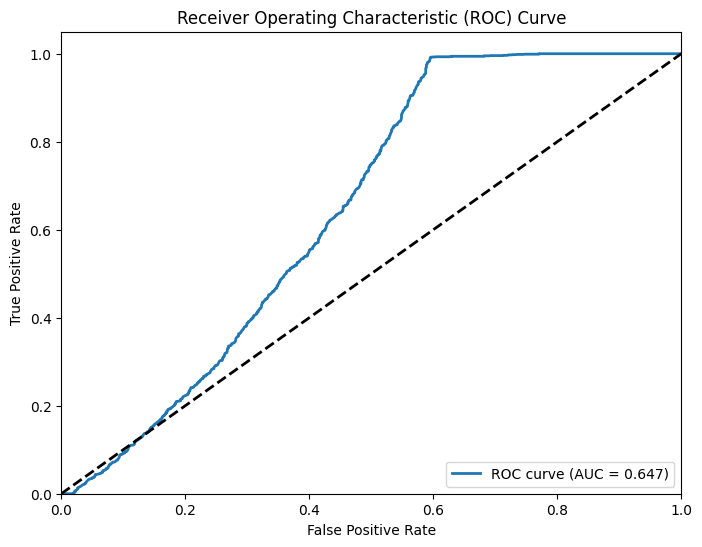

In [ ]:
# Assuming you have calculated the fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier()

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("XGBoost Classifier Results:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

XGBoost Classifier Results:
Accuracy: 0.71
Precision: 0.65
Recall: 0.95
F1 Score: 0.77
Confusion Matrix:
[[ 893  975]
 [  98 1784]]


## Loading Test dataset and pre-processing it

In [ ]:
# Load the test data from test.parquet
test_df = pd.read_parquet("test.parquet")

In [ ]:
test_df

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0
...,...,...,...
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8


#  Developing a positive and negative model (Test dataset)

In [ ]:
# Positive Set
positive_setT = test_df[test_df['Incident'] == 'TARGET DRUG']
positive_setT = positive_set.groupby('Patient-Uid')['Date'].min().reset_index()
positive_setT['Label'] = 1  # Set 'Label' to 1 for positive set

# Negative Set
negative_setT = test_df[~test_df['Patient-Uid'].isin(positive_set['Patient-Uid'])]

# Balance the negative set (adjust this part to match other characteristics)
negative_setT = negative_setT.sample(n=len(positive_set), random_state=42)

# Add 'Label' to the negative set and set it to 0
negative_setT['Label'] = 0

new_df1 = pd.concat([positive_set, negative_set])
new_df1.head()

,Patient-Uid,Date,Label,Time_diff,Incident
0,a0e9c384-1c7c-11ec-81a0-16262ee38c7f,2020-07-08,1,1235,NaN
1,a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f,2018-04-24,1,2041,NaN
2,a0e9c3e3-1c7c-11ec-a8b9-16262ee38c7f,2019-10-31,1,1486,NaN
3,a0e9c414-1c7c-11ec-889a-16262ee38c7f,2018-04-05,1,2060,NaN
4,a0e9c443-1c7c-11ec-9eb0-16262ee38c7f,2019-09-10,1,1537,NaN


In [ ]:
# Define the 'prediction_date' as 30 days from today
prediction_dateT = pd.to_datetime('today') + pd.DateOffset(days=30)

# Calculate 'Time_diff' for the positive set
positive_setT['Time_diff'] = (prediction_dateT - positive_setT.groupby('Patient-Uid')['Date'].transform('max')).dt.days

# Calculate 'Time_diff' for the negative set
negative_setT['Time_diff'] = (prediction_dateT - negative_setT.groupby('Patient-Uid')['Date'].transform('max')).dt.days

new_df1 = pd.concat([positive_setT, negative_setT])

# Final generated predicted model in .csv file

In [ ]:
# To create final submission file

test_data_pred = xgb_classifier.predict(new_df1[['Time_diff']])
final_submission = pd.DataFrame({'Patient-Uid': new_df1['Patient-Uid'], 'Prediction': test_data_pred})
final_submission.to_csv('Final_submission.csv', index=False)


In [ ]:
# Assuming you have a DataFrame named 'patient_events' with patient treatment events
# and 'ideal_duration' as the ideal treatment duration (in days)

# Convert dates to months
patient_events['Month'] = patient_events['Date'].dt.to_period('M')

# Group patients by month of drop-off
dropoff_counts = patient_events[patient_events['Incident'] == 'TARGET DRUG'].groupby('Month')['Patient-Uid'].nunique()


NameError: ignored

In [ ]:
train_df.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [ ]:
df = train_df

In [ ]:
df

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [ ]:
# Convert dates to months
df['Month'] = df['Date'].dt.to_period('M')

# Group patients by month of drop-off
dropoff_counts = df[df['Incident'] == 'TARGET DRUG'].groupby('Month')['Patient-Uid'].nunique()


In [ ]:
# Define a function to extract events before drop-off for a patient
def get_events_before_dropoff(patient_uid, dropoff_month):
    patient_data = df[(df['Patient-Uid'] == patient_uid) & (df['Month'] == dropoff_month)]
    return patient_data[patient_data['Date'] < patient_data[patient_data['Incident'] == 'TARGET DRUG']['Date'].min()]


In [ ]:
# Analyze events leading to drop-off
dropoff_reasons = []
for month, patients in dropoff_counts.items():
    for patient in df[df['Month'] == month]['Patient-Uid'].unique():
        events_before_dropoff = get_events_before_dropoff(patient, month)
        dropoff_reasons.extend(events_before_dropoff['Incident'])

# Now you have a list of events that occurred before drop-off, which may provide insights.


KeyboardInterrupt: ignored